# Scope project 

 This project aimed to create an ocr system for arabic language in 4 steps:
 - **Preprocessing** : in this step we will preprocess the image 
 - **Segmentation** : segmente the image and get caracters 
 - **Recognition** : recognize the extracted caracters using a machine learing model
 - **Deployment** : deploy the model and make avalaible for production 

# Importing libraries 

In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import time 
import os 

# Convert plate image to gray scale image

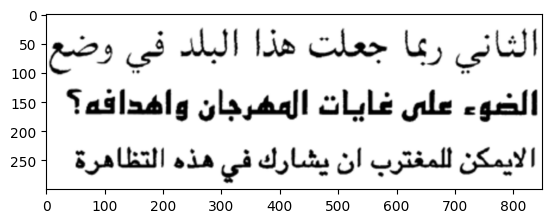

In [2]:
img = cv2.imread("../Test images/Test.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap="gray")

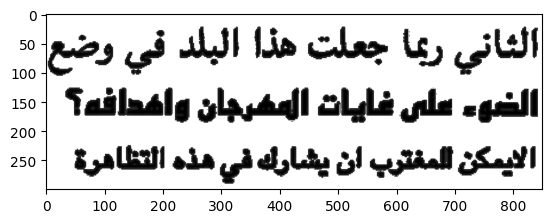

In [3]:
gray = cv2.equalizeHist(gray)
plt.imshow(gray, cmap="gray")

# Binarize the image 

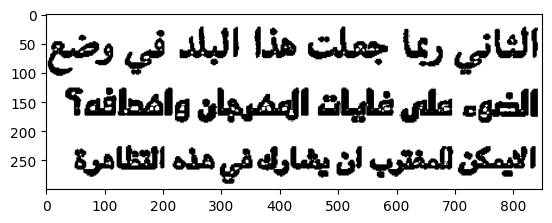

In [4]:
binary = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
)
plt.imshow(binary, cmap="gray")

In [5]:
def preProcessing(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray1 = cv2.equalizeHist(gray)
    binary = cv2.adaptiveThreshold(
        gray1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    
    cv2.imshow("gray", gray)
    cv2.waitKey(3000)
    cv2.destroyAllWindows()
    
    cv2.imshow("gray1", gray1)
    cv2.waitKey(3000)
    cv2.destroyAllWindows()
    
    cv2.imshow("binary", binary)
    cv2.waitKey(3000)
    cv2.destroyAllWindows()

In [6]:
preProcessing(img)

# Image segmentation and character extraction

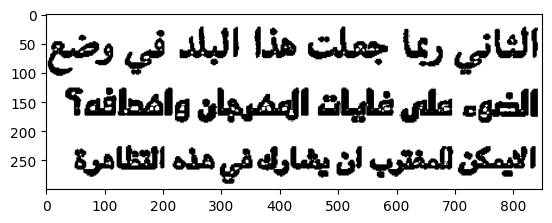

In [6]:
h, w = binary.shape 

if  w > 1000:
    new_w = 1000
    ar = w/h
    new_h = int(new_w/ar)
    binary = cv2.resize(binary, (new_w, new_h), interpolation = cv2.INTER_AREA)
plt.imshow(binary, cmap="gray")

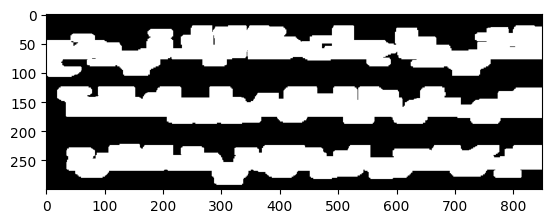

In [7]:

# Dilatation
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5, 30), np.uint8)
dilated = cv2.dilate(binary, kernel, iterations=1)
plt.imshow(dilated, cmap="gray")

In [8]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_countours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1])


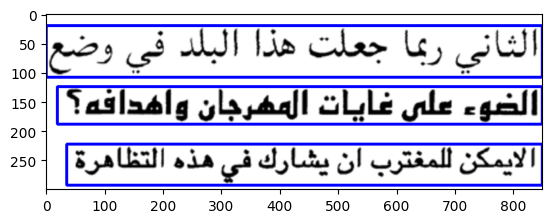

In [9]:
img2 = img.copy()
for ctr in sorted_countours_lines :
    x, y, w, h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x, y), (x+w, y+h), (0,0,255), 3)
    
plt.imshow(img2)

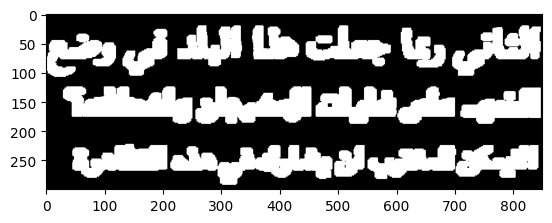

In [10]:

# Dilatation
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((5, 10), np.uint8)
dilated2 = cv2.dilate(binary, kernel, iterations=1)
plt.imshow(dilated2, cmap="gray")

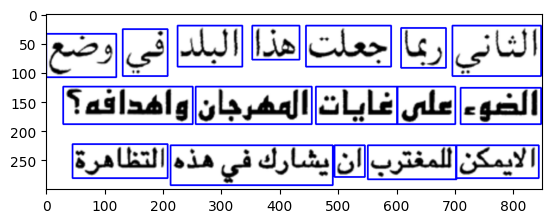

In [11]:
img3 = img.copy()
word_list = []
for line in sorted_countours_lines:
    # roi of each line
    x, y, w, h = cv2.boundingRect(line)
    roi_line = dilated2[y:y+w, x:x+w]
    
    # draw contours on each word 
    (cnt, heirarchy) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_word = sorted(cnt, key=lambda cntr : cv2.boundingRect(cntr)[0])
    
    for word in sorted_contours_word:
        if cv2.contourArea(word) < 500:
            continue
        x2, y2, w2, h2 = cv2.boundingRect(word)
        word_list.append([x+x2, y+y2, x+x2+w2, y+y2+h2])
        cv2.rectangle(img3, (x+x2, y+y2), (x+x2+w2, y+y2+h2), (0, 0, 255), 2)
        
plt.imshow(img3)

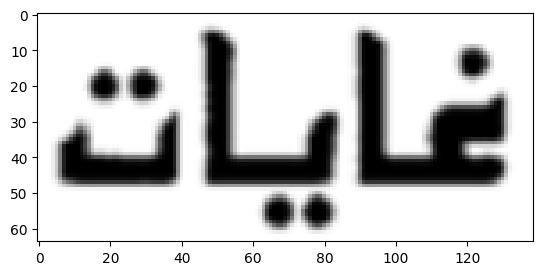

In [12]:
word_9 = word_list[9]
roi_9 = img[word_9[1]:word_9[3], word_9[0]:word_9[2]]
plt.imshow(roi_9)

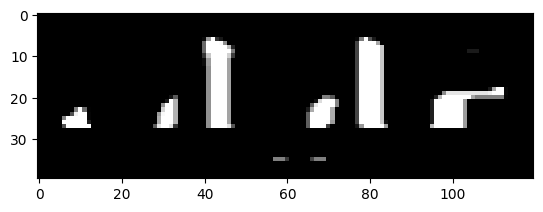

In [13]:
# Dilatation
_, binary = cv2.threshold(roi_9, 127, 255, cv2.THRESH_BINARY_INV)
kernel = np.ones((6, 1), np.uint8)
binary = cv2.resize(binary, (120,40))
dilated2 = cv2.erode(binary, kernel, iterations=1)

plt.imshow(dilated2, cmap="gray")

In [14]:
# Apply binary thresholding
_, thresh = cv2.threshold(roi_9, 127, 255, cv2.THRESH_BINARY_INV)
# Find contours of characters
contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours from right to left (Arabic is right-to-left)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0], reverse=True)

# Create a copy of the image for visualization
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Extract each character
characters = []
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    
    # Extract individual character
    char_crop = thresh[y:y+h, x:x+w]

    # Resize character for better recognition
    char_crop = cv2.resize(char_crop, (32, 32), interpolation=cv2.INTER_AREA)
    
    # Store the character
    characters.append(char_crop)
    
    # Draw bounding box on output image
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display extracted characters
fig, axes = plt.subplots(1, len(characters), figsize=(12, 3))
for ax, char in zip(axes, characters):
    ax.imshow(char, cmap="gray")
    ax.axis("off")
plt.show()


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


# OCR 

In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd

# Virsualization for data 
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# import Callbacks for EarlySttoping
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# important laibary for bulding Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D, MaxPooling2D, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from sklearn.utils import shuffle
from keras.utils import to_categorical

# Data Augmentation (THis is bonus :)  )
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0
X_train = np.expand_dims(X_train, -1 )
X_test = np.expand_dims(X_test, -1)
y_train = np.expand_dims(y_train, -1 )
y_test = np.expand_dims(y_test, -1)
X_test.shape, X_train.shape

((10000, 28, 28, 1), (60000, 28, 28, 1))

# Display some images

In [4]:
plt.figure(fig_size=(7,7))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(X_train[i])
    plt.title(y_train[i])

AttributeError: Figure.set() got an unexpected keyword argument 'fig_size'

# Load arabic character dataset

In [ ]:
#SPlit our data into 4 parts (x_train,x_test,y_train,y_test)
Xtrain=pd.read_csv('C:/Users/Hassan Kerroumi/Computer_Vision/Projet/Arabic/csvTrainImages 13440x1024.csv').to_numpy()
Xtest=pd.read_csv('C:/Users/Hassan Kerroumi/Computer_Vision/Projet/Arabic/csvTestImages 3360x1024.csv').to_numpy()
ytrain=pd.read_csv('C:/Users/Hassan Kerroumi/Computer_Vision/Projet/Arabic/csvTrainLabel 13440x1.csv').to_numpy()-1
ytest=pd.read_csv('C:/Users/Hassan Kerroumi/Computer_Vision/Projet/Arabic/csvTestLabel 3360x1.csv').to_numpy()-1

In [ ]:
# printing the Shape of data to show no rows,columns 
print('X_train shape is ',Xtrain.shape)
print('X_test shape is ',Xtest.shape)
print('y_train shape is ',ytrain.shape)
print('y_test shape is ',ytest.shape)

In [ ]:
# We Need to do Reshape our Data 
Xtrain = Xtrain.reshape(-1,32,32,1)
Xtest = Xtest.reshape(-1,32,32,1)

In [ ]:
ytrain, ytest  = ytrain+10, ytest+10

In [ ]:
# printing the Shape of data to show no rows,columns after Reshape
print('X_train shape is ',Xtrain.shape)
print('X_test shape is ',Xtest.shape)
print('y_train shape is ',ytrain.shape)
print('y_test shape is ',ytest.shape)

In [ ]:
Xtrain = tf.image.resize(Xtrain, (28, 28))
Xtest = tf.image.resize(Xtest, (28, 28))

In [ ]:
np.max(Xtrain[0])

In [ ]:
# printing the Shape of data to show no rows,columns after Reshape
print('X_train shape is ',Xtrain.shape)
print('X_test shape is ',Xtest.shape)
print('y_train shape is ',ytrain.shape)
print('y_test shape is ',ytest.shape)

# Load english character dataset

In [14]:
from imutils import paths
import cv2
import os
def load_dataset(path, classes_name):
    """ 
  It reads the images in the directory and creates their labels.

  Parameters:

  path: Refers to the directory where the images are located.
  Return:
   x: It stores the matrix information of the images.
  labels: A list that holds the class information of each image.
  """
    x = []
    labels = []
    # It lists and sorts the images in the specified path
    image_paths = sorted(list(paths.list_images(path)))
   
    for image_path in image_paths :
        # The images in the specified path are read using the OpenCV library
        img = cv2.imread(image_path)
        # resize the read image 
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # the resized images are added to the x list
        x.append(img)
         # When each path is split by '/', the second-to-last element of the resulting list represents the label
        label = image_path.split(os.path.sep)[-2]
        
        # The label is created by retrieving the corresponding value for the given key from the `waste_labels`

        # dictionary, which contains the numerical representations of the captured labels
        labels.append(classes_name[label])
        # the dataset is shuffled randomly
    x, labels = shuffle(x, labels, random_state = 42)
    print(f'X size : {np.array(x).shape}')
    print(f'Number of label classes {np.unique(labels)}, Number of observation in the dataset : {len(labels)}')
    
    return np.array(x), np.array(labels) 


In [15]:
classes_name = {
    '0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    'A': 39, 'B': 40, 'C': 41, 'D': 42, 'E': 43, 'F': 44, 'G': 45, 'H': 46, 'I': 47, 'J': 48,
    'K': 49, 'L': 50, 'M': 51, 'N': 52, 'O': 53, 'P': 54, 'Q': 55, 'R': 56, 'S': 57, 'T': 58,
    'U': 59, 'V': 60, 'W': 61, 'X': 62, 'Y': 63, 'Z': 64,
    'unknown': -1 
}
target_size = (28,28)
path1 = "C:/Users/Hassan Kerroumi/Computer_Vision/Projet/English/data/training_data"
path2 = "C:/Users/Hassan Kerroumi/Computer_Vision/Projet/English/data/testing_data"
path3 = "C:/Users/Hassan Kerroumi/Computer_Vision/Projet/English/data2/training_data"
path4 = "C:/Users/Hassan Kerroumi/Computer_Vision/Projet/English/data2/testing_data"

In [ ]:
x1, labels1 = load_dataset(path1, classes_name)
x2, labels2 = load_dataset(path2, classes_name)
x3, labels3 = load_dataset(path3, classes_name)


X size : (20628, 28, 28)
Number of label classes [ 0  1  2  3  4  5  6  7  8  9 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64], Number of observation in the dataset : 20628
X size : (1008, 28, 28)
Number of label classes [ 0  1  2  3  4  5  6  7  8  9 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62 63 64], Number of observation in the dataset : 1008


In [ ]:
x4, labels4 = load_dataset(path4, classes_name)

# Expand dimensions

In [ ]:
x1 = np.expand_dims(x1, -1)
x2 = np.expand_dims(x2, -1)
x3 = np.expand_dims(x3, -1)
x4 = np.expand_dims(x4, -1)
labels1 = np.expand_dims(labels1, -1)
labels2 = np.expand_dims(labels2, -1)
labels3 = np.expand_dims(labels3, -1)
labels4 = np.expand_dims(labels4, -1)

In [ ]:
np.max(x1[0])

# Print shapes 

In [ ]:
print("path1 ", x1.shape, labels1.shape)
print("path2 ", x2.shape, labels2.shape)
print("path3 ", x3.shape, labels3.shape)
print("path4 ", x4.shape, labels4.shape)

# Display some images

In [ ]:
plt.figure(fig_size=(7,7))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(x1[i])
    plt.title(labels1[i])

# Normalization

In [23]:
X_train, Xtrain, x1, x3  = X_train / 255.0, Xtrain / 255.0, x1 / 255.0, x3 / 255.0
X_test, Xtest, x2, x4 = X_test / 255.0, Xtest / 255.0, x2 / 255.0, x4 / 255.0

# Concatenate all data 

In [24]:
y_train.shape, y_test.shape

((60000, 1), (10000, 1))

In [25]:
all_xtrain = np.concatenate([X_train, Xtrain, x1, x3], axis = 0) 
all_xtest = np.concatenate([X_test, Xtest, x2, x4], axis = 0) 
all_ytrain = np.concatenate([y_train, ytrain, labels1, labels3], axis = 0)
all_ytest = np.concatenate([y_test, ytest, labels2, labels4], axis = 0)


In [26]:
np.max(all_xtrain[114101])

0.7764705882352941

# Split data to validation and test

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
all_xtest, X_val, all_ytest, y_val = train_test_split(all_xtest, all_ytest, test_size = 0.5, random_state = 42)

In [29]:
all_xtrain.shape

(114695, 28, 28, 1)

# Create a model 

In [47]:
NN_model = Sequential([
    # Layer 1
    Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', 
           activation='relu', input_shape=(28, 28, 1)),  # Output: (28, 28, 64)
    MaxPooling2D(pool_size=(2, 2)),                     # Output: (14, 14, 64)
    
    # Layer 2
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),  # Output: (14, 14, 128)
    MaxPooling2D(pool_size=(2, 2)),                                                          # Output: (7, 7, 128)
    
    # Layer 3
    Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),  # Output: (7, 7, 128)
    MaxPooling2D(pool_size=(2, 2)),                                                          # Output: (3, 3, 128)
    
    # Flatten and Fully Connected Layers
    Flatten(),                                                                              # Output: (1152)
    Dense(units=128, activation='relu'),
    Dropout(0.1),
    Dense(units=256, activation='relu'),
    Dropout(0.2),
    Dense(units=256, activation='relu'),
    Dropout(0.2),
    Dense(units=256, activation='relu'),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dropout(0.10),
    Dense(units=65, activation='softmax'),  # Output layer for 10 classes
])


In [48]:
NN_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 65)                  │           8,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 575,553 (2.20 MB)

 Trainable params: 575,553 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
NN_model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

In [50]:
callbacks = [EarlyStopping(monitor='val_accuracy',

                           patience=10,

                           verbose=1,

                           mode="max"),
             



             ModelCheckpoint(filepath='Res_Model_1.keras',

                             monitor='val_accuracy',
                             mode='max',

                             save_best_only=True,

                             save_weights_only=False,

                             verbose=1)]

In [51]:
history = NN_model.fit(all_xtrain, all_ytrain, epochs = 100,callbacks = callbacks, validation_data=(X_val, y_val) )

Epoch 1/100
3583/3585 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0918 - loss: 3.0318
Epoch 1: val_accuracy improved from -inf to 0.22921, saving model to Res_Model_1.keras
3585/3585 ━━━━━━━━━━━━━━━━━━━━ 130s 35ms/step - accuracy: 0.0919 - loss: 3.0314 - val_accuracy: 0.2292 - val_loss: 2.1541
Epoch 2/100
3583/3585 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3242 - loss: 1.8617
Epoch 2: val_accuracy improved from 0.22921 to 0.30452, saving model to Res_Model_1.keras
3585/3585 ━━━━━━━━━━━━━━━━━━━━ 113s 32ms/step - accuracy: 0.3242 - loss: 1.8617 - val_accuracy: 0.3045 - val_loss: 1.9275
Epoch 3/100
3584/3585 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3889 - loss: 1.6752
Epoch 3: val_accuracy improved from 0.30452 to 0.31213, saving model to Res_Model_1.keras
3585/3585 ━━━━━━━━━━━━━━━━━━━━ 111s 31ms/step - accuracy: 0.3889 - loss: 1.6751 - val_accuracy: 0.3121 - val_loss: 1.8690
Epoch 4/100
3584/3585 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4031 - loss: 1.6038
Epoch 4

3585/3585 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4739 - loss: 1.3934
Epoch 24: val_accuracy did not improve from 0.42537
3585/3585 ━━━━━━━━━━━━━━━━━━━━ 162s 45ms/step - accuracy: 0.4739 - loss: 1.3934 - val_accuracy: 0.4200 - val_loss: 1.5299
Epoch 25/100
3585/3585 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4780 - loss: 1.3754
Epoch 25: val_accuracy did not improve from 0.42537
3585/3585 ━━━━━━━━━━━━━━━━━━━━ 168s 47ms/step - accuracy: 0.4780 - loss: 1.3754 - val_accuracy: 0.4229 - val_loss: 1.5088
Epoch 26/100
3585/3585 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4730 - loss: 1.3999
Epoch 26: val_accuracy did not improve from 0.42537
3585/3585 ━━━━━━━━━━━━━━━━━━━━ 170s 47ms/step - accuracy: 0.4730 - loss: 1.3999 - val_accuracy: 0.4240 - val_loss: 1.5052
Epoch 27/100
3584/3585 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4751 - loss: 1.3798
Epoch 27: val_accuracy did not improve from 0.42537
3585/3585 ━━━━━━━━━━━━━━━━━━━━ 175s 49ms/step - accuracy: 0.4751 - loss: 1.

276/276 - 3s - 11ms/step - accuracy: 0.4592 - loss: 1.4154


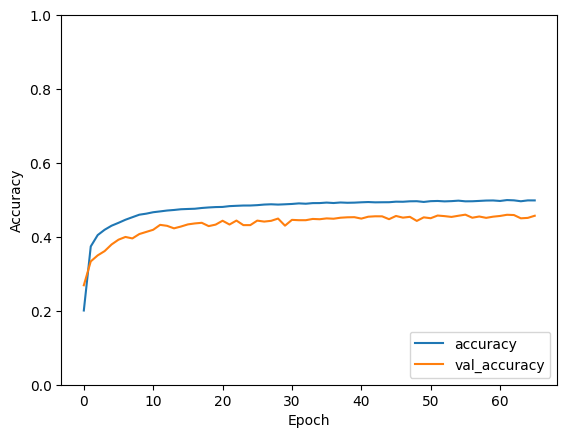

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = NN_model.evaluate(all_xtest,  all_ytest, verbose=2)

# Test

In [1]:
from tensorflow.keras.models import load_model
NN_model = load_model("Res_Model_1.keras")
#test_loss, test_acc = NN_model.evaluate(all_xtest,  all_ytest, verbose=2)

C:\Users\Hassan Kerroumi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Make prediction

In [2]:
pathT = "C:/Users/Hassan Kerroumi/Computer_Vision/Projet/Computer-Vision/Images/characters"
classe_name = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',  
    'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 
    'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 
    'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ي',           
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',  
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',  
    'U', 'V', 'W', 'X', 'Y', 'Z',                      
    'unknown'                                          
]


In [10]:
def load_test(path):
   
    x = []
    # It lists and sorts the images in the specified path
    image_paths = sorted(list(paths.list_images(path)))
   
    for image_path in image_paths :
        # The images in the specified path are read using the OpenCV library
        img = cv2.imread(image_path)
        # resize the read image 
        img = cv2.resize(img, (28,28))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # the resized images are added to the x list
        img = np.expand_dims(img, -1)
        x.append(img)
      
    print(f'X size : {np.array(x).shape}')
    
    return np.array(x)

In [11]:
test = load_test(pathT)

X size : (7, 28, 28, 1)


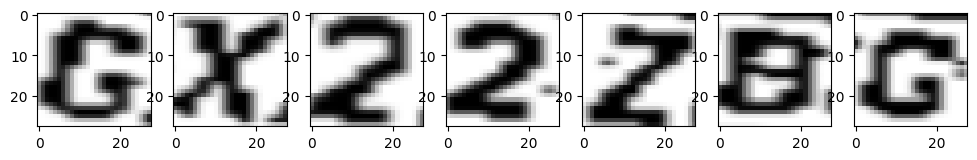

In [12]:
plt.figure(figsize=(12,12))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.imshow(test[i], cmap="gray")

In [15]:
prediction = ""
for i in range(7):
    l = []
    l.append(test[i])
    y_pred = NN_model.predict(np.array(l) / 255.0)
    predicted_class_index = np.argmax(y_pred)
    prediction += classe_name[predicted_class_index]
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class name: {classe_name[predicted_class_index]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted class index: 45
Predicted class name: H
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class index: 62
Predicted class name: Y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class index: 2
Predicted class name: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class index: 2
Predicted class name: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted class index: 64
Predicted class name: unknown
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted class index: 0
Predicted class name: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted class index: 41
Predicted class name: D


In [14]:
prediction

'HY22unknown0D'